In [1]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20,8))

In [2]:
import gmsh 
import numpy as np

gmsh.initialize()    # esto es como abrir un programa 
gmsh.model.add('testeo') #creo el modelo que modificare
lc=1
L=10
p1=gmsh.model.geo.addPoint(0,0,0,lc)
p2=gmsh.model.geo.addPoint(2*L,0,0,lc)
p3=gmsh.model.geo.addPoint(2*L,L,0,lc)
p4=gmsh.model.geo.addPoint(0,L,0,lc)
l1=gmsh.model.geo.addLine(p1,p2)
l2=gmsh.model.geo.addLine(p2,p3)
l3=gmsh.model.geo.addLine(p3,p4)
l4=gmsh.model.geo.addLine(p4,p1)
c1=gmsh.model.geo.addCurveLoop([l1,l2,l3,l4])
s1=gmsh.model.geo.addPlaneSurface([c1])
gmsh.model.geo.synchronize()

Empotrado=gmsh.model.addPhysicalGroup(1,[l4])
gmsh.model.setPhysicalName(1,Empotrado,'Empotrado')

Traccionado=gmsh.model.addPhysicalGroup(1,[l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[s1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')


gmsh.model.mesh.generate(2)


NodeInfo = gmsh.model.mesh.get_nodes()
NumeroNodos=NodeInfo[0].shape[0]

MN=NodeInfo[1].reshape(NumeroNodos,3)

ETAGS,ELEMENTS=gmsh.model.mesh.get_elements_by_type(2)

MC=ELEMENTS.reshape([ETAGS.shape[0],3])

MC=(MC-1).astype(int) # etiquetas de los nodos con notacion python


NodosEmpotrados=gmsh.model.mesh.get_nodes_for_physical_group(1,Empotrado)
CE=NodosEmpotrados[1].reshape(NodosEmpotrados[0].shape[0],3) # son las coordenadas.

s=NodosEmpotrados[0].reshape(len(NodosEmpotrados[0]),1) # etiquetas de los nodos empotrados
z=np.zeros([len(NodosEmpotrados[0]),2])
MNE=np.concatenate((s-1,z),axis=1)  # etiquetas de los nodos con notacion python
MNE=MNE.astype(int)


NodosTraccionados=gmsh.model.mesh.get_nodes_for_physical_group(1,Traccionado)

# MDF_comment por qué guardas todos los ceros ?
s=NodosTraccionados[0].reshape(len(NodosTraccionados[0]),1).astype(int) # etiquetas de los nodos traccionados
z=np.zeros([len(NodosTraccionados[0]),2]).astype(int)
MNT=np.concatenate((s-1,z),axis=1) # etiquetas de los nodos con notacion python


# encuentro las fuerzas ejercidas en cada nodo del extremo empotrado
entityTraccionada=gmsh.model.getEntitiesForPhysicalGroup(1,Traccionado)
Tgroup,Ttraccionada,Ltraccionada=gmsh.model.mesh.getElements(1,entityTraccionada[0])
Ltraccionada=Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2) #es la matriz de conectividad de los elementos linea del extremo traccionado 
Longitudes=np.abs(MN[Ltraccionada[:,0]-1,1]-MN[Ltraccionada[:,1]-1,1])

t=1 #[inch]
Tension_ext=10000/L
MDFMNT = MNT.copy()
for s in range(len(Ltraccionada)):
    flocal=Tension_ext*Longitudes[s]*t/2
    flocal=round(flocal)
    #MDF_COMMENT el problema de hacerlo así es que te queda mal acomodado el nodo 2, que esta en una punta pero es el segundo de la lista! la lista de nodos 
    #MDF_COMMENT hay que sacarla de la Matriz de Conectividad de las líneas. Ltraccionada: 
    MNT[s,1]+=flocal
    MNT[s+1,1]+=flocal

In [3]:
for l,linea in enumerate(Ltraccionada):
    n1 = int(linea[0]-1)   # el -1 es para numerar desde cero
    n2 = int(linea[1]-1)
    flocal=Tension_ext*Longitudes[l]*t/2
    flocal=round(flocal)
    MDFMNT[MDFMNT[:,0]==n1,1] += flocal
    MDFMNT[MDFMNT[:,0]==n2,1] += flocal
    

In [4]:
MNT

array([[   1,  500,    0],
       [   2, 1000,    0],
       [  23, 1000,    0],
       [  24, 1000,    0],
       [  25, 1000,    0],
       [  26, 1000,    0],
       [  27, 1000,    0],
       [  28, 1000,    0],
       [  29, 1000,    0],
       [  30, 1000,    0],
       [  31,  500,    0]])

In [5]:
MDFMNT

array([[   1,  500,    0],
       [   2,  500,    0],
       [  23, 1000,    0],
       [  24, 1000,    0],
       [  25, 1000,    0],
       [  26, 1000,    0],
       [  27, 1000,    0],
       [  28, 1000,    0],
       [  29, 1000,    0],
       [  30, 1000,    0],
       [  31, 1000,    0]])

In [6]:
Longitudes

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
MNE

array([[ 0,  0,  0],
       [ 3,  0,  0],
       [51,  0,  0],
       [52,  0,  0],
       [53,  0,  0],
       [54,  0,  0],
       [55,  0,  0],
       [56,  0,  0],
       [57,  0,  0],
       [58,  0,  0],
       [59,  0,  0]])

In [8]:
# gmsh.fltk.run() # notese que los nodos en MNT, MNE estan retrasados en 1 respecto al mesh 

eso es porque en python se numeran los índices desde cero mientras que en gmsh los nodos se numeran desde 1. Hay que tener cuidado !

In [9]:
np.set_printoptions(precision = 4, linewidth = 132)
cp=0.3
E=30000000 #[Psi]

nb=len(MNE)
nc=len(MNT)

D=np.array([[1,cp,0],
            [cp,1,0],
            [0,0,0.5*(1-cp)]] )*E/(1-cp**2)
n=len(MN)
x=np.arange(n) 
x=np.delete(x,[np.concatenate((MNE[:,0].astype(int),MNT[:,0].astype(int)))]) #tiene adentro los nodos en los que no se pusieron condiciones



In [10]:
kglobal=np.zeros([len(MN)*2,len(MN)*2])
B=[]
for i in range (len(MC)):
    A=np.linalg.det([[1,MN[MC[i,0],0],MN[MC[i,0],1]],
                    [1,MN[MC[i,2],0],MN[MC[i,2],1]],
                    [1,MN[MC[i,1],0],MN[MC[i,1],1]]])/2
    
    
    bi=MN[MC[i,2],1]-MN[MC[i,1],1]
    gi=MN[MC[i,1],0]-MN[MC[i,2],0]
    
    bj=MN[MC[i,1],1]-MN[MC[i,0],1]
    gj=MN[MC[i,0],0]-MN[MC[i,1],0]
    
    bm=MN[MC[i,0],1]-MN[MC[i,2],1]
    gm=MN[MC[i,2],0]-MN[MC[i,0],0]
    
    B.append(np.array([[bi,0,bj,0,bm,0],
                       [0,gi,0,gj,0,gm],
                       [gi,bi,gj,bj,gm,bm]])*(1/(2*A)))
    

    k= t * abs(A) * (np.dot(np.transpose(B[i]), np.dot(D,B[i])))
    
    i,m,j = MC[i,:]    
    index=np.array([i*2,i*2+1,j*2,j*2+1,m*2,m*2+1])
    kglobal[np.ix_(index,index)]+=k

    #print(B/(1/(2*A)))
    #print(A)
    #print(k/(75000/0.91))
    #print(kglobal*(0.91/375000))

In [11]:
#creo matriz de fuerzas 
#f[i,0]=1 se conoce la fuerza
#f[i,0]=0 no se conoce la fuerza
#f[i,1]=valor ,si la fuerza se conoce su valor estara en la segunda columna.
f=np.zeros([2*n,2])
# introduzco a la matriz f las fuerzas conocidas
for i in range (nc):
    s=MNT[i,0]
    f[2*(s),0]=1
    f[2*(s),1]=MNT[i,1]
    f[2*(s)+1,0]=1
    f[2*(s)+1,1]=MNT[i,2]
    
# introduzco al vector f las fuerzas que son 0 porque no conozco su desplazamiento
for j in range (nb):
    if MNE[j,1]==1:
        s=MNE[j,0]
        f[2*s,0]=1
        f[2*s,1]=0
    if MNE[j,2]==1:
        s=MNE[j,0]
        f[2*s+1,0]=1
        f[2*s+1,1]=0
if nb+nc <n:
    f[2*(x),0]=1
    f[2*(x),1]=0
    f[2*(x)+1,0]=1
    f[2*(x)+1,1]=0


Guardamos las fuerzas para ver como queda:

In [12]:
vfext = gmsh.view.add('Fuerzas Externas')

In [13]:
_FX=f[0:-1:2,1].reshape(-1,1)

_FY =f[1::2,1].reshape(-1,1)

(-1.0, 30.0)

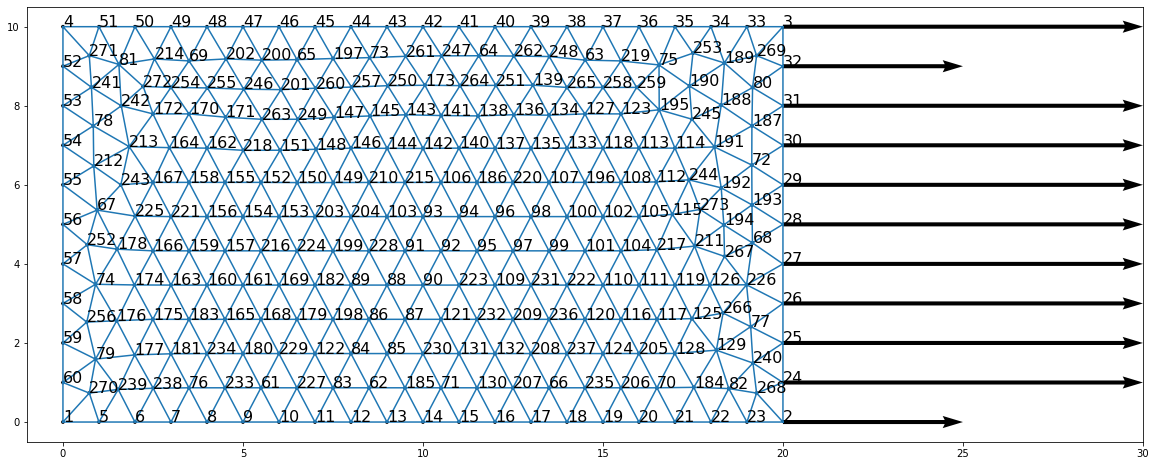

In [14]:
fig, ax = plt.subplots()

_ax = ax.triplot(MN[:,0], MN [:,1], MC)
_ax = ax.quiver(MN[:,0], MN[:,1], _FX, _FY,scale=100, units='x')
for n in range(NumeroNodos):
    ax.annotate('{:d}'.format(n+1), MN[n,:2], fontsize=16)
ax.set_xlim([-1,30])

Veamos como queda con la numeración nueva:

In [15]:
#creo matriz de fuerzas 
#f[i,0]=1 se conoce la fuerza
#f[i,0]=0 no se conoce la fuerza
#f[i,1]=valor ,si la fuerza se conoce su valor estara en la segunda columna.
MDFf=np.zeros([2*NumeroNodos,2])
# introduzco a la matriz f las fuerzas conocidas
for i in range (nc):
    s=MDFMNT[i,0]
    MDFf[2*(s),0]=1
    MDFf[2*(s),1]=MDFMNT[i,1]
    MDFf[2*(s)+1,0]=1
    MDFf[2*(s)+1,1]=MDFMNT[i,2]
    
# introduzco al vector f las fuerzas que son 0 porque no conozco su desplazamiento
for j in range (nb):
    if MNE[j,1]==1:
        s=MNE[j,0]
        MDFf[2*s,0]=1
        MDFf[2*s,1]=0
    if MNE[j,2]==1:
        s=MNE[j,0]
        MDFf[2*s+1,0]=1
        MDFf[2*s+1,1]=0
if nb+nc <n:
    MDFf[2*(x),0]=1
    MDFf[2*(x),1]=0
    MDFf[2*(x)+1,0]=1
    MDFf[2*(x)+1,1]=0


In [72]:
MDFf

array([[  0.,   0.],
       [  0.,   0.],
       [  1., 500.],
       ...,
       [  1.,   0.],
       [  1.,   0.],
       [  1.,   0.]])

In [16]:
_MDFFX=MDFf[0:-1:2,1].reshape(-1,1)

_MDFFY =MDFf[1::2,1].reshape(-1,1)

(-1.0, 30.0)

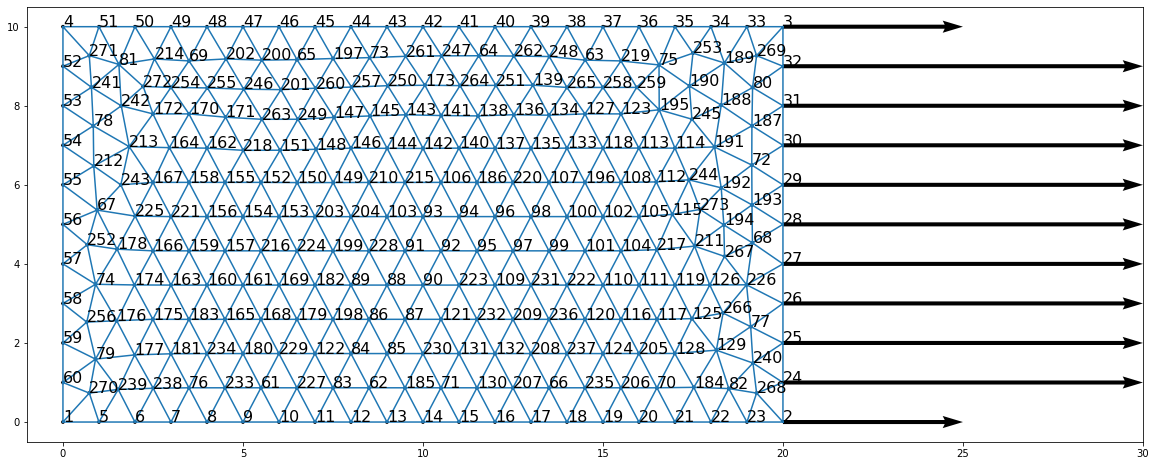

In [17]:
fig, ax = plt.subplots()

_ax = ax.triplot(MN[:,0], MN [:,1], MC)
_ax = ax.quiver(MN[:,0], MN[:,1], _MDFFX, _MDFFY,scale=100, units='x')
for n in range(NumeroNodos):
    ax.annotate('{:d}'.format(n+1), MN[n,:2], fontsize=16)
ax.set_xlim([-1,30])

In [18]:
f[2*2,1]

1000.0

In [19]:
gmsh.view.addModelData(vfext, 0,'testeo', 'NodeData',NodeInfo[0], np.hstack([_FX,_FY,np.zeros_like(_FX)]))

In [20]:
# gmsh.fltk.run()

te queda reviar a partir de aca abajo!

In [73]:
# Busco los indices para seleccionar las componentes de la matriz Kglobal
indexf=[]  # indices de fuerzas conocidas 
indexd=[]  # indices de desplazamientos conocidos  
contador=0
for k in range(2*NumeroNodos): #n):
    #MDF_COMMENT if f[k,0]==1 :
    if MDFf[k,0]==1 :
        indexf.append(k)
        contador+=1
    else:
        indexd.append(k)

In [74]:
indexd

[0,
 1,
 6,
 7,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119]

fijate que los indices 0,1 son del nodo 1 que deberia estar en indexf, pero lo estas poniendo en indexd. 

In [91]:
mdfindexf=np.sort( np.hstack( [ 2*(NodosEmpotrados[0]-1) , 2*(NodosEmpotrados[0]-1)+1 ] ) )

In [92]:
mdfindexf

array([  0,   1,   6,   7, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], dtype=uint64)

In [96]:
mdfindexd = np.delete( np.arange(2*NumeroNodos) , mdfindexf )

In [98]:
# selecciono las componentes de Kglobal y resuelvo [F]=[K'][u] como [K']^-1[F]=[u] teniendo K' las componentes seleccionadas 
#segun las fuerzas conocidas desde un principio:

desplazamientos=np.dot(np.linalg.inv(kglobal[np.ix_(indexf,indexf)]),f[indexf,1])
#creo el vector desplazamientos, la notacion es igual que en el vetor fuerzas:
#MDF_COMMENT d=np.zeros([2*n,2]) la arruine poniendo n algun contador
d = np.zeros([2*NumeroNodos,2])
d[indexd,0]=1 
d[indexf,1]=desplazamientos
f[:,1]=np.dot(kglobal,d[:,1]) # obtuve las fuerzas faltantes, paso demas 

me falta terminar de acomodar pero tengo que ponerme a trabajar un rato. 

In [117]:
# selecciono las componentes de Kglobal y resuelvo [F]=[K'][u] como [K']^-1[F]=[u] teniendo K' las componentes seleccionadas 
#segun las fuerzas conocidas desde un principio:

mdfdesplazamientos=np.dot(np.linalg.inv(kglobal[np.ix_(mdfindexd,mdfindexd)]),MDFf[mdfindexd,1])  # acordate que te falta la parte de los desplazamientos en esta ecuacion !

#creo el vector desplazamientos, la notacion es igual que en el vetor fuerzas:
#MDF_COMMENT d=np.zeros([2*n,2]) la arruine poniendo n algun contador
MDFd = np.zeros([2*NumeroNodos,2])
MDFd[mdfindexd,0]=1 
MDFd[mdfindexf,1]=mdfdesplazamientos
MDFf[:,1]=np.dot(kglobal,MDFd[:,1]) # obtuve las fuerzas faltantes, paso demas 

ValueError: shape mismatch: value array of shape (524,)  could not be broadcast to indexing result of shape (22,)

In [58]:
tension=[0,0,0]
for s in range (len(MC)) :
    i,m,j = MC[s,:]    
    index=np.array([i*2,i*2+1,j*2,j*2+1,m*2,m*2+1])
    valor=np.dot(np.dot(B[s],d[index,1]),D)
    tension=np.vstack((tension,valor))
    
tension=np.delete(tension,0,axis=0)

In [101]:
MDFtension=[0,0,0]
for s in range (len(MC)) :
    i,m,j = MC[s,:]    
    index=np.array([i*2,i*2+1,j*2,j*2+1,m*2,m*2+1])
    valor=np.dot(np.dot(B[s],MDFd[index,1]),D)
    MDFtension=np.vstack((MDFtension,valor))
    
MDFtension=np.delete(tension,0,axis=0)

In [59]:
tensionmax=[0]
for p in range (len(tension)):
    valor=(tension[p,0]+tension[p,1])/2+np.sqrt((tension[p,0]-tension[p,1])/2+tension[p,2]**2)
    tensionmax=np.vstack((tensionmax,valor))
tensionmax=np.delete(tensionmax,0,axis=0)



In [103]:
MDFtensionmax=[0]
for p in range (len(MDFtension)):
    valor=(tension[p,0]+tension[p,1])/2+np.sqrt((MDFtension[p,0]-MDFtension[p,1])/2+MDFtension[p,2]**2)
    tensionmax=np.vstack((tensionmax,valor))
MDFtensionmax=np.delete(tensionmax,0,axis=0)



In [60]:
# separo las componente "x" e "y" del vector deplazamiento 
ip=[]
ii=[]
desplazamiento=[]
for q in range(len(d)):
    if q%2==0:
        ip.append(q)
    else:
        ii.append(q)
a=d[ip,1].reshape(len(ip),1)

b=d[ii,1].reshape(len(ii),1)



In [111]:
MDFDx = mdfdesplazamientos[:-1:2].reshape(-1,1)
MDFDy = mdfdesplazamientos[1::2].reshape(-1,1)

In [109]:

DESP=np.hstack((a,b,np.zeros([len(a),1])))

In [115]:
mdfdesplazamientos

array([-1.1055e-05, -4.4369e-07, -1.2271e-05,  1.2721e-06, -7.7900e-06,  2.7270e-06, -7.8108e-06,  3.0444e-06, -7.9293e-06,
        2.5700e-06, -8.3889e-06,  1.8929e-06, -7.5336e-06,  4.1416e-07, -7.2645e-06,  5.6451e-07, -7.2463e-06, -8.9009e-07,
       -7.3422e-06, -6.4264e-07, -7.8144e-06, -1.6682e-06])

In [112]:

MDFDESP=np.hstack((MDFDx,MDFDy,np.zeros([len(a),1])))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 11 and the array at index 2 has size 273

In [62]:

desps = gmsh.view.add("desplazamientos")



In [63]:

Desps = gmsh.view.addModelData(desps, 0, 'testeo', 'NodeData', NodeInfo[0], DESP, numComponents=3)
#en orden del argumento anterior: 
#view donde guardo los datos
#0(hace algo con el tiempo)
#nombre del modelo del mesh)
#NodeData implica que el valor que que estoy guardando esta relacionado a los nodos , puede ser NodeData,ElemenData.
#etiquetas de los nodos/elementos a los que se le asigna "desps" 
#Valores de lo que asigno
#dimension de aquello que le estoy dando como valores 

# hay una forma de poner un "video" en la visualizacion del mesh , ver script de Mariano 
# tambien hay maneras de como exportar los resultados, ver script de Mariano  

In [64]:
Tensiones=gmsh.view.add('Tensiones principales')

In [65]:
Tensiones = gmsh.view.addModelData(Tensiones, 0, 'testeo', 'ElementData', ETAGS, tensionmax , numComponents=1 )

In [66]:
X, Y = np.meshgrid(MN[:,0], MN[:,1])

(-1.0, 30.0)

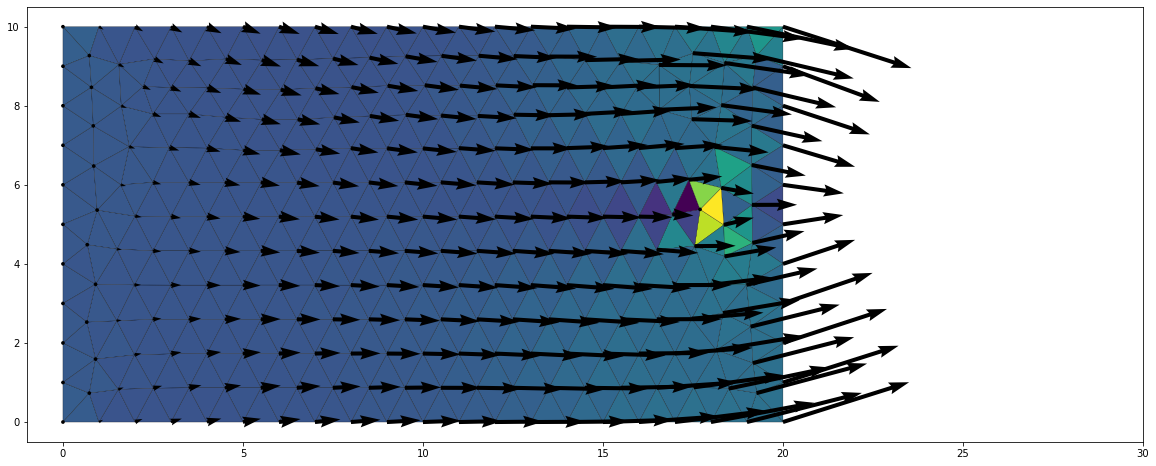

In [69]:
fig, ax = plt.subplots()

_ax =ax.tripcolor(MN[:,0], MN[:,1], MC, facecolors = tensionmax.ravel(), label='$\sigma_{max}$', edgecolor='k' )
#_ax =ax.triplot(MN[:,0], MN[:,1], MC, )
ax.quiver(MN[:,0], MN[:,1], DESP[:,0], DESP[:,1], units='x')
ax.set_xlim([-1,30])

para mí todavía hay algo mal con los desplazamientos!

In [ ]:
tension

In [ ]:
gmsh.fltk.run()
